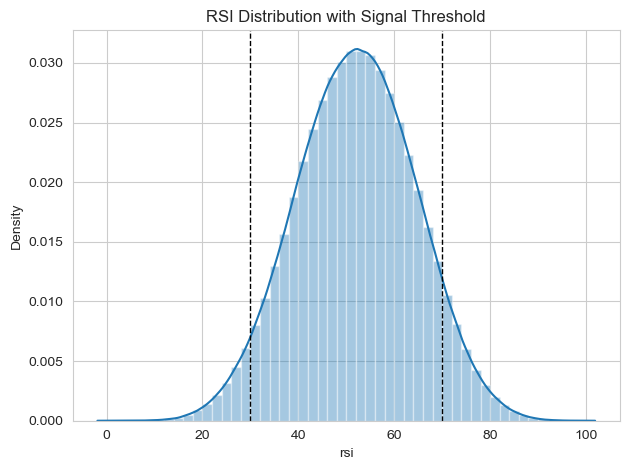

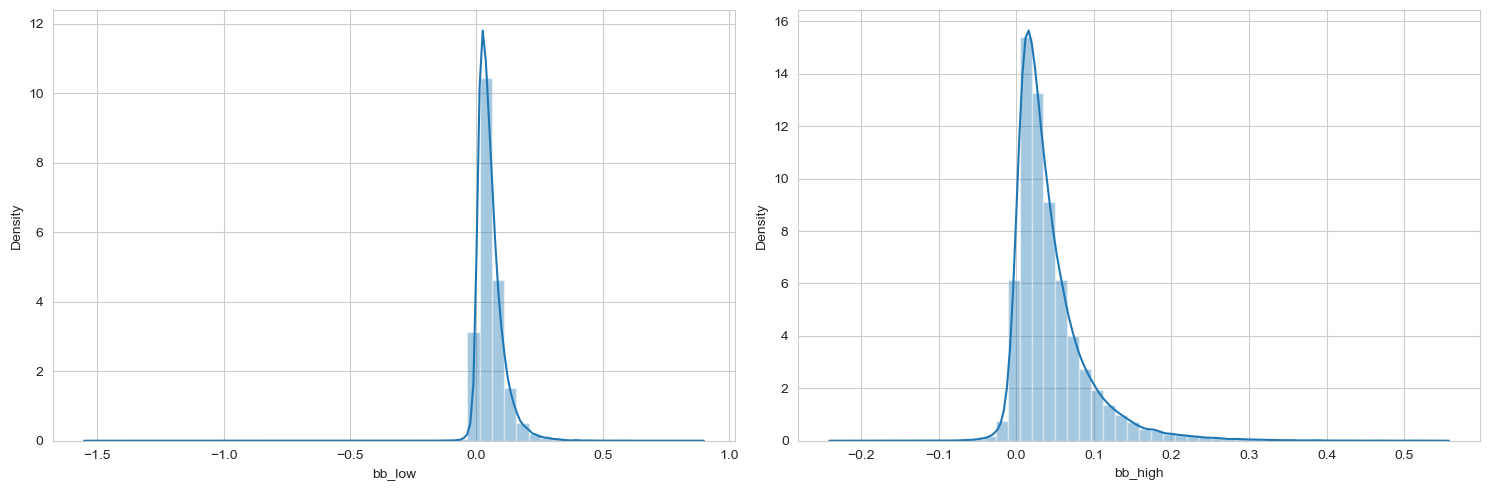

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

MONTH = 21
YEAR = 12 * MONTH

START = '2013-01-01'
END = '2017-12-31'

sns.set_style('whitegrid')
idx = pd.IndexSlice

# Loading Quandl Wiki Stock Prices & Meta Data

ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

DATA_STORE = './data/assets.h5'

# ['/us_equities/stocks', '/sp500/fred', '/sp500/stocks', '/quandl/wiki/prices', '/quandl/wiki/stocks']

with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

# Remove stocks with few observations

# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

# Align price and meta data

stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

# So, prices.index.get_level_values('ticker').unique() effectively 
# gives you a list of all the unique stock tickers represented in your prices DataFrame. 
# This is useful for identifying all the different stocks included in your dataset, 
# especially when you want to perform operations or analyses on a per-stock basis.
# In summary, .intersection(stocks.index) finds the common stock tickers that exist 
# in both your prices and stocks datasets. 
# This is crucial for ensuring that any analysis you conduct later on is based on stocks 
# for which you have complete information from both datasets.

shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

# In summary, this line of code enhances your prices DataFrame with a new metric: 
# the 1-month rolling average of dollar volume for each stock. 
# This metric can be particularly useful for analyzing trends in trading volume over time 
# and identifying periods of unusual activity.
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker').rolling(window=21).mean()).values

# By adding this ranking, you're creating a way to easily identify which stocks had the highest 
# and lowest trading volumes over a rolling 1-month period on any given date.
prices['dollar_vol_rank'] = (prices.groupby('date').dollar_vol_1m.rank(ascending=False))

# Add some Basic Factors
# Compute the Relative Strength Index
prices['rsi'] = prices.groupby(level='ticker').close.transform(lambda x: RSI(x))

ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();


def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

# Apply the function and reset index
bb_data = (prices.groupby(level='ticker')
           .close
           .apply(compute_bb)
           .reset_index(level=1, drop=True))

# Join the data
prices = prices.join(bb_data)

prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();


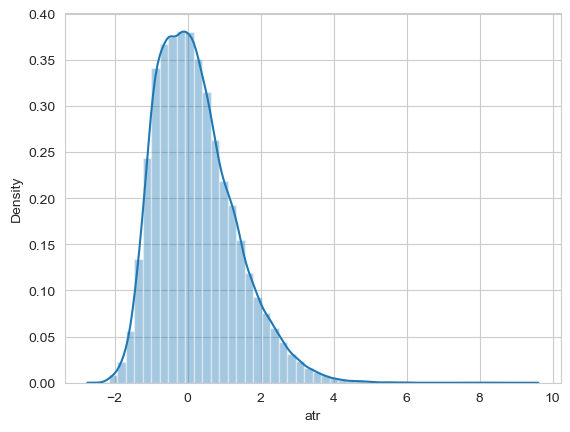

In [2]:

# Compute Average True Range

def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());



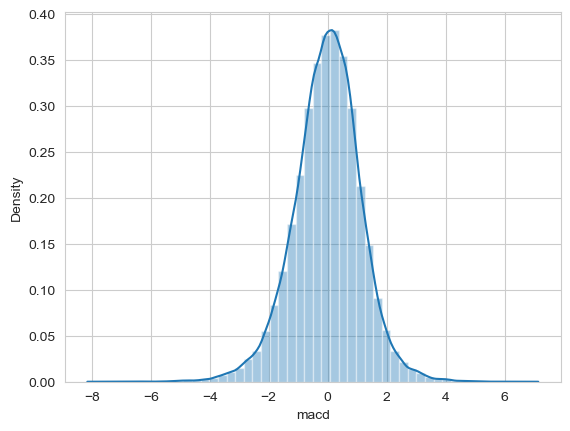

In [3]:

# Compute Moving Average Convergence/Divergence

def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

In [4]:

# Compute Lagged Returns

lags = [1, 5, 10, 21, 42, 63]

returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')



,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


In [5]:
q = 0.0001

# Winsorize outliers

for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

# Shift lagged returns

for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

# Compute Forward Returns

for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

# Combine Price and Meta Data

stocks.rename(columns={'sector': 'new_sector_name'}, inplace=True)
prices = prices.join(stocks[['new_sector_name']])

# Create time and sector dummy variables

prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)




AttributeError: 'DataFrame' object has no attribute 'sector'

In [ ]:

# Store Model Data

prices.to_hdf('data.h5', 'model_data')

# Explore Data
# Plot Factors

target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

# RSI

top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

top100.groupby('rsi_signal')['target_5d'].describe()



In [ ]:

# Bollinger Bands

metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')


metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')


# ATR

metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')


# MACD

metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

